# Dog Image Classification Using Transfer Learning on AWS

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


This notebook contains the code to -
1. Download the dog image data and then upload it to an S3 bucket.
2. Create a Hyperparameter Tuning job to tune three parameters for an image classification model using transfer learning.
3. Get the best hyperparameter combinations and create a final model using those. Also, add debugger and profiler to monitor the training.
4. Deploy the resulting model to an endpoint and check if it works by querying it.
5. Delete any active endpoints.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-01-25 16:58:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.152
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  37.3MB/s    in 45s     

2022-01-25 16:59:34 (23.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [4]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "dog-image-data"
role = sagemaker.get_execution_role()

In [8]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-199549374973/dog-image-data


In [6]:
print(inputs)

s3://sagemaker-us-east-1-199549374973/dog-image-data


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16,32,64]),
    "epochs": IntegerParameter(2,4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
from sagemaker.pytorch import PyTorch

#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [9]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}) # TODO: Remember to include your data channels

...........................................................................................................................................................................................................!


In [10]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-26 15:50:25 Starting - Preparing the instances for training
2022-01-26 15:50:25 Downloading - Downloading input data
2022-01-26 15:50:25 Training - Training image download completed. Training in progress.
2022-01-26 15:50:25 Uploading - Uploading generated training model
2022-01-26 15:50:25 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '2',
 'lr': '0.0010569163218645224',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-26-15-33-34-997"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-199549374973/pytorch-training-2022-01-26-15-33-34-997/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [123]:
hyperparameters = {
    "lr": "0.0010569163218645224",
    "batch-size": "64",
    "epochs":  "2"
}

In [124]:
from sagemaker.debugger import Rule, rule_configs, ProfilerRule

In [125]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

In [126]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10",
                    "eval.save_interval": "10"}
)

In [127]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dogImageClassifier",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version="py3",
    framework_version="1.4",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
    
)

estimator.fit({"train": inputs})

2022-02-06 20:03:47 Starting - Starting the training job...
2022-02-06 20:04:12 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-02-06 20:05:12 Downloading - Downloading input data............
2022-02-06 20:07:13 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-06 20:07:06,979 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-06 20:07:06,983 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-06 20:07:06,999 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-06 20:07:07,003 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-06 20:07:07,418 sagemaker-co

In [128]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: dogImageClassifier-2022-02-06-20-03-46-640
Region: us-east-1


In [129]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-02-06 20:46:28.540 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/debug-output


In [130]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-02-06 20:46:29.983 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-06 20:46:31.004 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.1.bn1.bias', 'gradient/ResNet_layer1.1.bn1.weight', 'gradient/ResNet_layer1.1.bn2.bias', 'gradient/ResNet_layer1.1.bn2.weight', 'gradient/ResNet_layer1.1.conv1.weight', 'gradient/ResNet_layer1.1.conv2.weight', 'gradient/ResNet_layer2.0.bn1.bias', 'gradient/ResNet_layer2.0.bn1.

In [131]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-199549374973/', 'ProfilingIntervalInMilliseconds': 1000, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/profiler-output


Profiler data from system is available


In [132]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-199549374973/', 'ProfilingIntervalInMilliseconds': 1000, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/profiler-output


Profiler data from system is available


In [133]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/rule-output


In [134]:
! aws s3 ls {rule_output_path} --recursive

2022-02-06 20:43:28     329711 dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-06 20:43:27     171075 dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-06 20:43:24        192 dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-06 20:43:24        200 dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-06 20:43:24        126 dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-06 20:43:24        127 dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-06 20:43:24        199 dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-outp

In [135]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-03-46-640/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-199549374973/dogImageClassifier-2022-02-06-20-0

In [136]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [137]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [138]:
# TODO: Plot a debugging output.

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [139]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


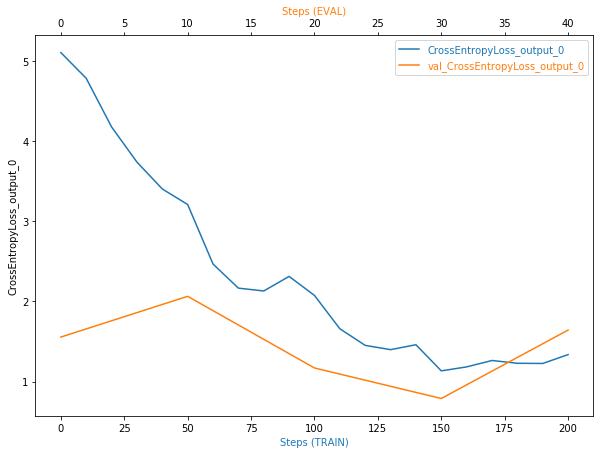

In [140]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

The plot looks fine. The training loss decreases and the validation loss first decreases and then increases a litte bit. 

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Look at the training loss, if the loss is not decreasing we can say that the model is not learning. We could then change some hyperparameters like the learning rate, etc.

## Model Deploying

In [141]:
# loading the model manually from its location in S3
model_location = estimator.model_data

In [142]:
import smdebug

In [143]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [144]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [145]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference2.py', py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [146]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

In [147]:
img_file_name = "dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg"
with open(img_file_name, "rb") as f:
    payload = f.read()
    
type(payload)

bytes

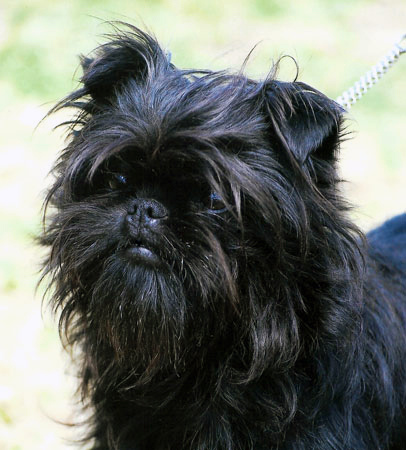

In [148]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [149]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[4.785614967346191,
  -5.876262664794922,
  -7.945693492889404,
  -7.899125099182129,
  -9.34716796875,
  -7.559183120727539,
  -9.837433815002441,
  -7.633178234100342,
  -6.912012577056885,
  -9.335098266601562,
  -8.14130973815918,
  -6.355746746063232,
  -5.54944372177124,
  -8.28929328918457,
  -11.29911994934082,
  -8.414518356323242,
  -5.3681111335754395,
  -9.146519660949707,
  -9.774500846862793,
  -10.505655288696289,
  -6.219871520996094,
  -8.119227409362793,
  -9.120991706848145,
  -5.739152908325195,
  -10.01486873626709,
  -1.436987042427063,
  -10.930564880371094,
  -7.965036392211914,
  -5.29470682144165,
  -3.874913215637207,
  -9.761907577514648,
  -5.2805280685424805,
  -2.2604267597198486,
  -5.865331649780273,
  -6.668230056762695,
  -1.989173412322998,
  -7.4077043533325195,
  0.9870749711990356,
  -7.74799919128418,
  -5.110034465789795,
  -5.647317409515381,
  -0.16268156468868256,
  -9.560400009155273,
  -6.230180263519287,
  -8.458740234375,
  -4.6240568161

In [150]:
import numpy as np
np.argmax(response, 1)

array([0])

We get the correct prediction

In [151]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()